In [1]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns  # Added import for seaborn
import keras
import tensorflow as tf
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models
from tensorflow.keras.layers import SpatialDropout2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import backend as K
from pyswarm import pso
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2D, multiply, add

In [2]:
base_path = r'C:\Users\KOJOGAH\Desktop\school\FINAL YEAR PROJECT\FYPDS7'
normal_path = os.path.join(base_path, 'Normal')
tumor_paths = [
    os.path.join(base_path, 'Tumor', 'glioma_tumor'),
    os.path.join(base_path, 'Tumor', 'meningioma_tumor'),
    os.path.join(base_path, 'Tumor', 'pituitary_tumor')
]

In [3]:
def normalize_image(img):
    min_val = np.min(img)
    max_val = np.max(img)
    return (img - min_val) / (max_val - min_val)

In [4]:
def display_images(images, labels, class_labels):
    for img, label in zip(images, labels):
        plt.imshow(img)
        plt.title(f"Class: {class_labels[label]}")
        plt.axis('off')
        plt.show()

In [5]:
def imagearray(path, size, label, class_labels, max_images=None):
    img_arrays = []
    labels = []

    count = 0
    for entry in os.listdir(path):
        entry_path = os.path.join(path, entry)

        if os.path.isfile(entry_path):
            img_arr = cv2.imread(entry_path)

            if img_arr is not None:
                img_arr = cv2.resize(img_arr, size)
                img_arrays.append(img_arr)
                labels.append(label)
                count += 1

                if max_images is not None and count >= max_images:
                    break
            else:
                print(f"Error: Could not read image at {entry_path}")

    return img_arrays, labels

In [6]:
desired_size = (224, 224)

In [7]:
normal_images, normal_labels = imagearray(normal_path, desired_size, label=0, class_labels={0: 'Normal'})

In [8]:
tumor_images = []
tumor_labels = []

In [9]:
for tumor_path, label in zip(tumor_paths, range(1, len(tumor_paths) + 1)):
    tumor_type = os.path.basename(tumor_path)
    images, labels = imagearray(tumor_path, desired_size, label=label, class_labels={0: 'Normal', label: tumor_type})
    tumor_images.extend(images)
    tumor_labels.extend(labels)

In [10]:
all_images = normal_images + tumor_images
all_labels = normal_labels + tumor_labels

In [11]:
# Convert lists to NumPy arrays
x = np.array(all_images)

y = np.array(all_labels)

In [12]:
# Split the data into training, testing, and validation sets
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.33, random_state=42)

In [13]:
# Label encoding using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

In [14]:
# Print the shapes of the resulting sets
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of x_val:", x_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of x_train: (15170, 224, 224, 3)
Shape of y_train: (15170,)
Shape of x_test: (4356, 224, 224, 3)
Shape of y_test: (4356,)
Shape of x_val: (2146, 224, 224, 3)
Shape of y_val: (2146,)


In [15]:
# Function for displaying images based on class
def display_images_by_class(images, labels, class_labels, num_per_class=1):
    unique_classes = np.unique(labels)
    images_to_display = []

    for class_label in unique_classes:
        class_indices = np.where(labels == class_label)[0]

        if class_indices.size > 0:
            # Display the first num_per_class images of the class
            images_to_display.extend(images[class_indices[:num_per_class]])

    # Display the images
    display_images(images_to_display, unique_classes, class_labels)

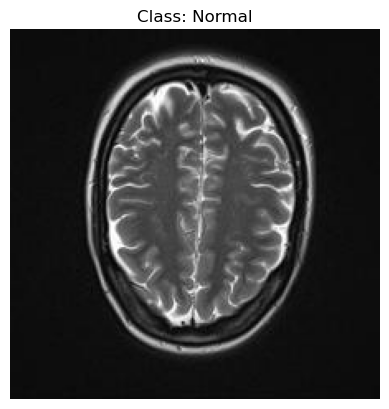

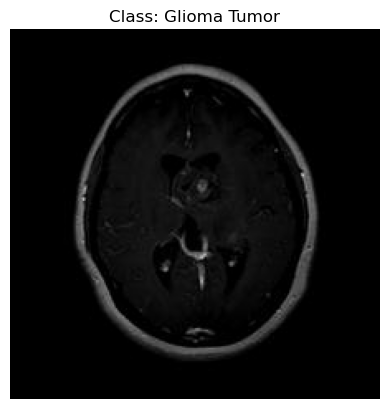

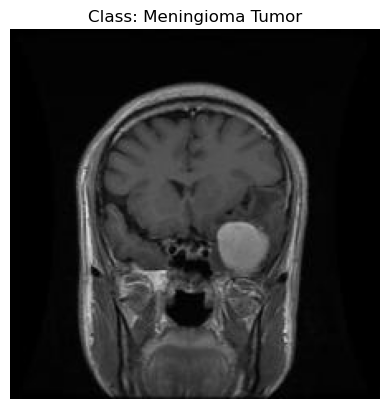

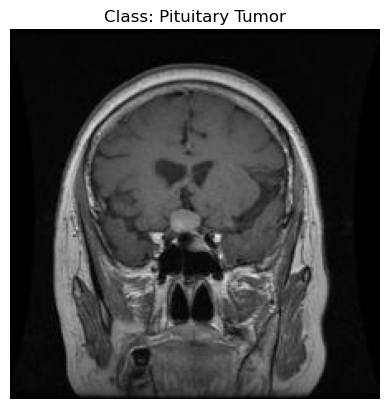

In [16]:
# Display sample images from each class
display_images_by_class(x_train, y_train, class_labels={0: 'Normal', 1: 'Glioma Tumor', 2: 'Meningioma Tumor', 3: 'Pituitary Tumor'})

In [17]:
# Function to create and compile the VGG19 model with spatial attention
def spatial_attention(input_tensor):
    squeeze = tf.reduce_mean(input_tensor, axis=[3], keepdims=True)
    excitation = Conv2D(1, (1, 1), strides=(1, 1), activation='sigmoid')(squeeze)
    scaled_input = multiply([input_tensor, excitation])
    return add([input_tensor, scaled_input])


In [18]:
# Function to create and compile the VGG19 model
def create_vgg19_model_with_attention(input_shape, num_classes):
    vgg = VGG19(input_shape=input_shape, weights="imagenet", include_top=False)

    for layer in vgg.layers:
        layer.trainable = False

    x = spatial_attention(vgg.layers[-5].output)  # Add attention after the last convolutional layer
    x = Flatten()(x)
    prediction = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=vgg.input, outputs=prediction)
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model


In [19]:
# Create and compile the model
model = create_vgg19_model_with_attention(input_shape=(224, 224, 3), num_classes=len(label_encoder.classes_))
model.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                           

In [20]:
# Train the model
early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

history = model.fit(x_train, y_train_encoded,
                    validation_data=(x_val, y_val_encoded),
                    epochs=3,
                    callbacks=[early_stop],
                    batch_size=32,
                    shuffle=True)

Epoch 1/3


475/475 [==============================] - 1019s 2s/step - loss: 243.6626 - accuracy: 0.8142 - val_loss: 133.7602 - val_accuracy: 0.8844
Epoch 2/3
475/475 [==============================] - 1007s 2s/step - loss: 72.9966 - accuracy: 0.9312 - val_loss: 120.7205 - val_accuracy: 0.9268
Epoch 3/3
475/475 [==============================] - 1002s 2s/step - loss: 49.7102 - accuracy: 0.9542 - val_loss: 91.7376 - val_accuracy: 0.9371


<function matplotlib.pyplot.show(close=None, block=None)>

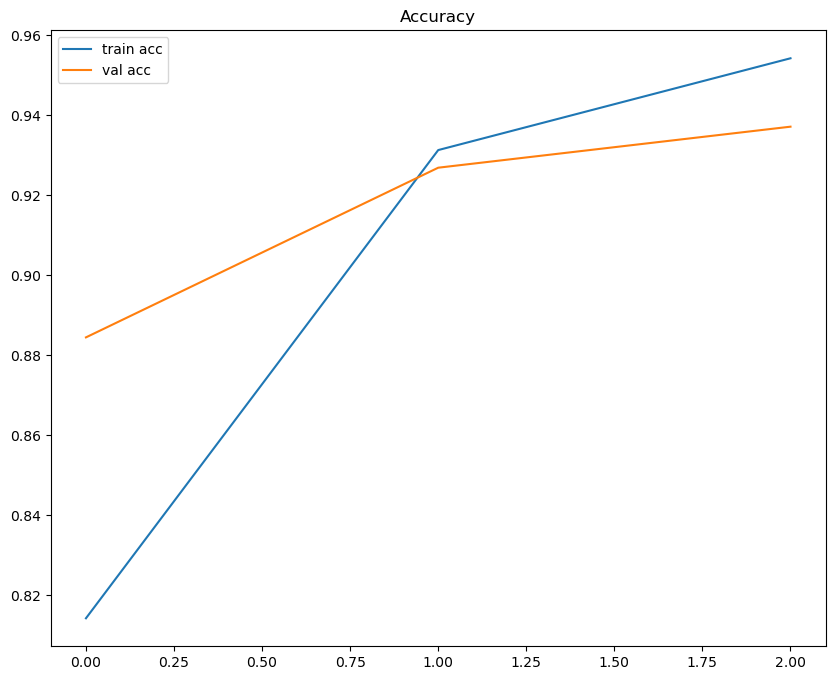

In [21]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

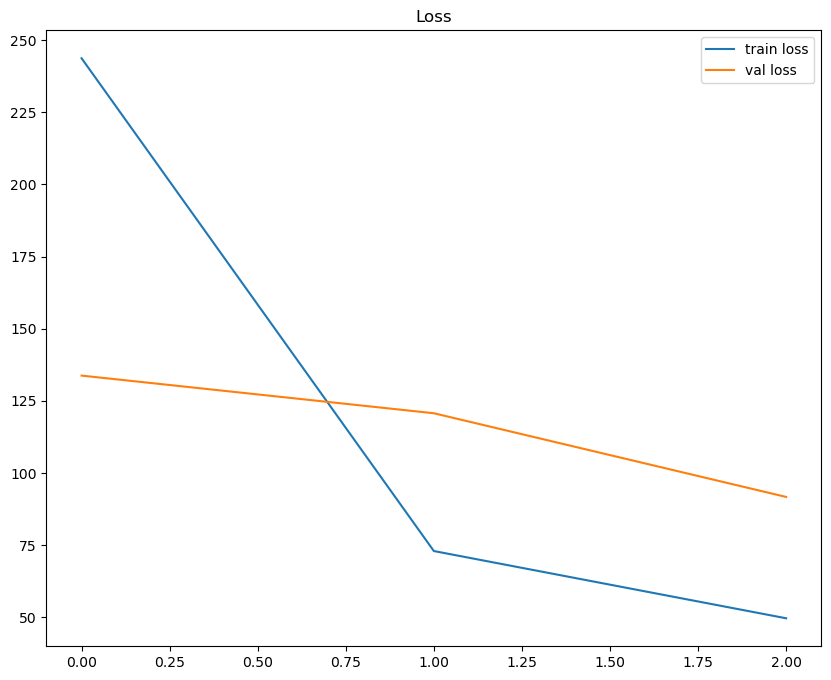

In [22]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show

In [23]:
# Evaluate the model on the test set
model.evaluate(x_test, label_encoder.transform(y_test), batch_size=32)

137/137 [==============================] - 249s 2s/step - loss: 95.9394 - accuracy: 0.9371


[95.93939971923828, 0.9370982646942139]

In [24]:
# Make predictions on the test set
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

137/137 [==============================] - 254s 2s/step


In [25]:
# Print classification report and confusion matrix
print(classification_report(label_encoder.transform(y_test), y_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       608
           1       0.91      0.95      0.93      1275
           2       0.95      0.89      0.92      1296
           3       0.98      0.95      0.97      1177

    accuracy                           0.94      4356
   macro avg       0.93      0.94      0.94      4356
weighted avg       0.94      0.94      0.94      4356



In [26]:
cm = confusion_matrix(label_encoder.transform(y_test), y_pred)

[Text(0, 0.5, 'Normal'),
 Text(0, 1.5, 'Glioma'),
 Text(0, 2.5, 'Meningioma'),
 Text(0, 3.5, 'Pituitary')]

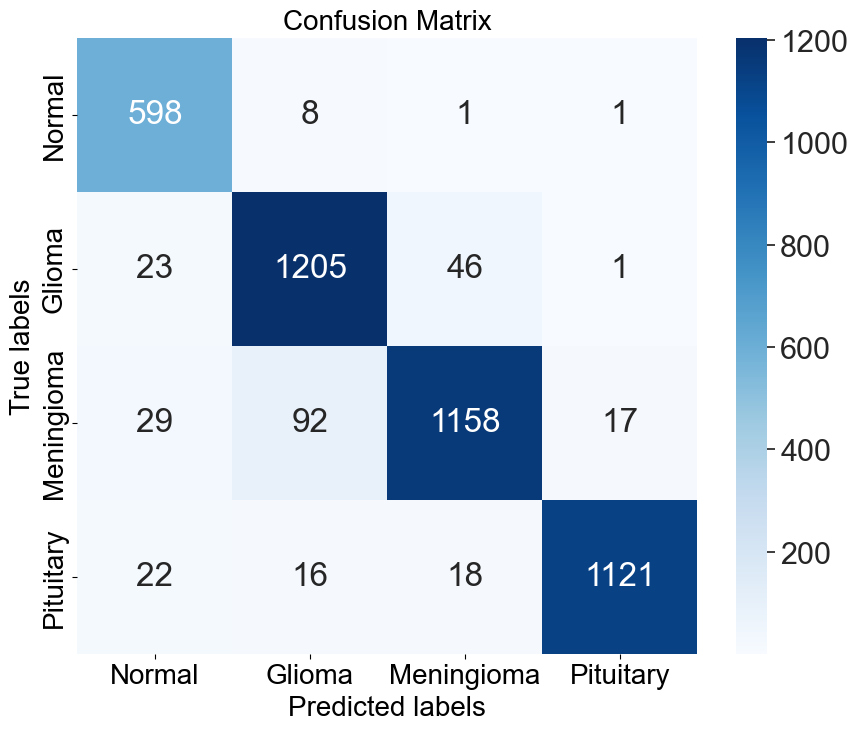

In [27]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)  # Corrected syntax error
ax.xaxis.set_ticklabels(['Normal', 'Glioma', 'Meningioma', 'Pituitary'], fontsize=20)
ax.yaxis.set_ticklabels(['Normal', 'Glioma', 'Meningioma', 'Pituitary'], fontsize=20)

In [28]:
# Calculate and print F1 score, recall, precision and accuracy
f1 = f1_score(label_encoder.transform(y_test), y_pred, average='micro')
recall = recall_score(label_encoder.transform(y_test), y_pred, average='weighted')
precision = precision_score(label_encoder.transform(y_test), y_pred, average='micro')
accuracy = accuracy_score(label_encoder.transform(y_test), y_pred)

In [29]:
print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("Accuracy:", accuracy)

F1 Score: 0.9370982552800735
Recall: 0.9370982552800735
Precision: 0.9370982552800735
Accuracy: 0.9370982552800735
